# Generate inclusion burden map for a sample slide

In [15]:
# Prelims
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import json
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
import openslide
from scipy.ndimage import gaussian_filter

# Import modified wildcat
sys.path.append("wildcat.pytorch")
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:        0 MB


## Experiment Setup

In [19]:
# Set the experiment directory
exp_dir = "/home/me/data/patches/exp01"

# Set the WSI file to process
wsi_file = "/home/me/data/wsi/slide.svs"

# Size of the training patch used to train wildcat, in raw pixels
patch_size_raw = 224

# Size of the window used to apply WildCat. Should be larger than the patch size
# This does not include the padding
window_size_raw = 2240

## Load Configuration and Models

In [20]:
# Set main directories
data_dir = os.path.join(exp_dir, "patches")
model_dir = os.path.join(exp_dir, "models")

# Load model configuration from config.json
with open(os.path.join(model_dir, 'config.json'), 'r') as jfile:
    config = json.load(jfile)

# Set global properties
num_classes=config['num_classes']
input_size=config['wildcat_upsample']['input_size']
batch_size=config['wildcat_upsample']['batch_size']

In [21]:
# Create the model
model_ft=resnet50_wildcat_upsample(
    config['num_classes'], 
    pretrained=True, 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'], 
    num_maps=config['wildcat_upsample']['num_maps'])

# Read model state
model_ft.load_state_dict(
    torch.load(os.path.join(model_dir, "wildcat_upsample.dat")))

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft.eval()
model_ft = model_ft.to(device)

Sending loaded model to device:  cuda:0


## Load WSI

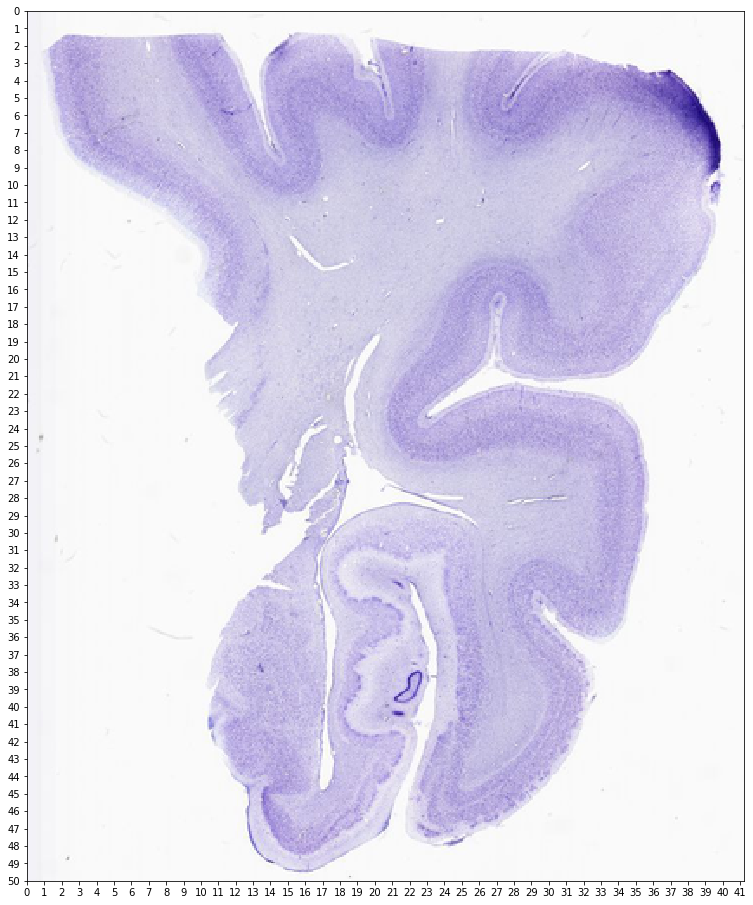

In [22]:
# Read a slide and show thumbnail
osl=openslide.OpenSlide(wsi_file)
plt.figure(figsize=(16,16))
plt.imshow(osl.get_thumbnail((512,512)), 
           extent=(0,osl.level_dimensions[0][0]/window_size_raw,osl.level_dimensions[0][1]/window_size_raw,0))
ax = plt.gca()
plt.xticks(np.arange(0,osl.level_dimensions[0][0]/window_size_raw));
plt.yticks(np.arange(0,osl.level_dimensions[0][1]/window_size_raw));

## Generate burden map
To speed this up, you can specify a sub-range of pixels to process

In [23]:
# u_range,v_range = None,None
u_range,v_range = (18,24),(28,48)

In [24]:

# The amount of padding, relative to patch size to add to the window. This padding
# is to provide context at the edges of the window
padding_size_rel = 1.0
padding_size_raw = int(padding_size_rel * patch_size_raw)

# Dimensions of the input image
slide_dim = np.array(osl.dimensions)

# Factor by which wildcat shrinks input images when mapping to segmentations
wildcat_shrinkage=2

# Additional shrinkage to apply to output (because we don't want to store very large)
# output images
extra_shrinkage=4

# Size of output pixel (in input pixels)
out_pix_size = wildcat_shrinkage * extra_shrinkage * patch_size_raw * 1.0 / input_size

# The output size for each window
window_size_out = int(window_size_raw / out_pix_size)

# The padding size for the output
padding_size_out = int(padding_size_rel * patch_size_raw / out_pix_size)

# Total number of non-overlapping windows to process
n_win = np.ceil(slide_dim / window_size_raw).astype(int)

# Output image size 
out_dim=(n_win * window_size_out).astype(int)

# Output array (last dimension is per-class probabilities)
density=np.zeros((2, out_dim[0], out_dim[1]))

# Range of pixels to scan
u_range = (0,n_win[0]) if u_range is None else u_range
v_range = (0,n_win[1]) if v_range is None else v_range

# Range non-overlapping windows
t_00 = timeit.default_timer()
for u in range(u_range[0], u_range[1]):
    for v in range(v_range[0], v_range[1]):
        
        # Get the coordinates of the window in raw pixels
        x,y,w = u*window_size_raw,v*window_size_raw,window_size_raw
        
        # Subtract the padding
        xp,yp,wp = x-padding_size_raw,y-padding_size_raw,window_size_raw+2*padding_size_raw
        
        # Read the chunk from the image
        t0 = timeit.default_timer()
        chunk_img=osl.read_region((xp,yp), 0, (wp,wp)).convert("RGB")
        t1 = timeit.default_timer()
                
        # Compute the desired size of input to wildcat
        wwc = int(wp * input_size / patch_size_raw)

        # Resample the chunk for the two networks
        tran = transforms.Compose([
            transforms.Resize((wwc,wwc)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Convert the read chunk to tensor format
        with torch.no_grad():
            
            # Apply transforms and turn into correct-size torch tensor
            chunk_tensor=torch.unsqueeze(tran(chunk_img),dim=0).to(device)
            
            # Forward pass through the wildcat model
            x_clas = model_ft.forward_to_classifier(chunk_tensor)
            x_cpool = model_ft.spatial_pooling.class_wise(x_clas)

            # Scale the cpool image to desired size
            x_cpool_up = torch.nn.functional.interpolate(x_cpool, scale_factor=1.0/extra_shrinkage).detach().cpu().numpy()

            # Extract the central portion of the output
            p0,p1 = padding_size_out,(padding_size_out+window_size_out)
            x_cpool_ctr = x_cpool_up[:,:,p0:p1,p0:p1]
            
            # Stick it into the output array
            xout0,xout1 = u * window_size_out, ((u+1) * window_size_out)
            yout0,yout1 = v * window_size_out, ((v+1) * window_size_out)
            density[0,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,0,:,:].transpose()
            density[1,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,1,:,:].transpose()
                
        # Finished first pass through the chunk
        t2 = timeit.default_timer()
        
        # At this point we have a list of hits for this chunk
        print("Chunk: (%6d,%6d) Times: IO=%6.4f WldC=%6.4f Totl=%8.4f" %
              (u,v,t1-t0,t2-t1,t2-t0))
        
# Trim the density array to match size of input
out_dim_trim=np.round((slide_dim/out_pix_size)).astype(int)
density=density[:,0:out_dim_trim[0],0:out_dim_trim[1]]

/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Chunk: (    18,    28) Times: IO=0.4478 WldC=1.1058 Totl=  1.5536
Chunk: (    18,    29) Times: IO=0.4653 WldC=1.0552 Totl=  1.5204
Chunk: (    18,    30) Times: IO=0.4330 WldC=1.0447 Totl=  1.4777
Chunk: (    18,    31) Times: IO=0.4341 WldC=1.0420 Totl=  1.4761
Chunk: (    18,    32) Times: IO=0.4028 WldC=1.0494 Totl=  1.4522
Chunk: (    18,    33) Times: IO=0.4236 WldC=1.0362 Totl=  1.4598
Chunk: (    18,    34) Times: IO=0.4138 WldC=1.0435 Totl=  1.4573
Chunk: (    18,    35) Times: IO=0.4093 WldC=1.0428 Totl=  1.4521
Chunk: (    18,    36) Times: IO=0.4052 WldC=1.0512 Totl=  1.4564
Chunk: (    18,    37) Times: IO=0.4271 WldC=1.0421 Totl=  1.4692
Chunk: (    18,    38) Times: IO=0.4162 WldC=1.0441 Totl=  1.4603
Chunk: (    18,    39) Times: IO=0.4121 WldC=1.0417 Totl=  1.4538
Chunk: (    18,    40) Times: IO=0.4021 WldC=1.0469 Totl=  1.4490
Chunk: (    18,    41) Times: IO=0.4384 WldC=1.0470 Totl=  1.4854
Chunk: (    18,    42) Times: IO=0.4226 WldC=1.0441 Totl=  1.4667
Chunk: (  

In [25]:
# Compute the default v_range
v_range_def = (-12,12)

# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample,vrange=v_range_def,sigma=0,show_ticks=True):
    # The image region
    img_rgn=osl.read_region((u0,v0), d_sample,
                            (int((u1-u0)/osl.level_downsamples[d_sample]),
                             int((v1-v0)/osl.level_downsamples[d_sample])))
    
    # The tangle map
    o_u0 = int(u0 / out_pix_size)
    o_v0 = int(v0 / out_pix_size)
    o_u1 = int(u1 / out_pix_size)
    o_v1 = int(v1 / out_pix_size)
    t_map=density[1,o_u0:o_u1,o_v0:o_v1].transpose()-density[0,o_u0:o_u1,o_v0:o_v1].transpose()
    t_map=np.where(t_map > 0, t_map, 0)
    
    # Smooth the tangle map
    t_map = gaussian_filter(t_map, sigma)
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    ax[0].grid(color='black', linestyle='-', linewidth=0.5)
    cs=ax[1].imshow(t_map, plt.get_cmap("jet"), vmin=vrange[0], vmax=vrange[1], extent=(u0,u1,v1,v0))
    ax[1].grid(color='black', linestyle='-', linewidth=0.5)
    # ax[1].colorbar(cs)
    if show_ticks is False:
        ax[0].xaxis.set_ticklabels([])
        ax[1].xaxis.set_ticklabels([])
        ax[0].yaxis.set_ticklabels([])
        ax[1].yaxis.set_ticklabels([])
    fig.show()

# Visualize burden map

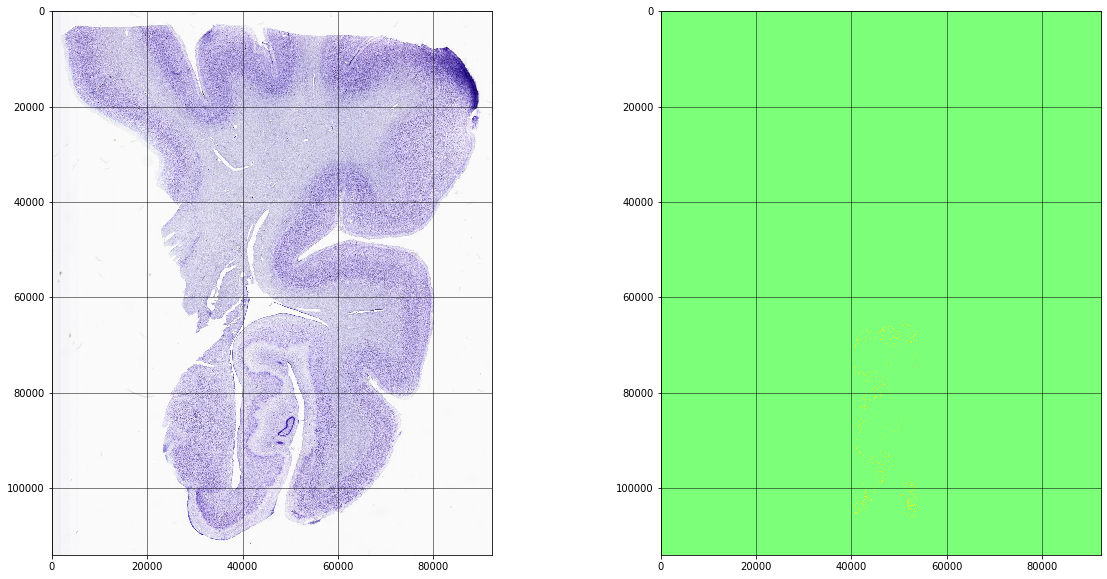

In [26]:
# plot_classification_region(7500,5000,42500,40000,2,(-3,3),10, show_ticks=True)
plot_classification_region(0,0,slide_dim[0],slide_dim[1],6)

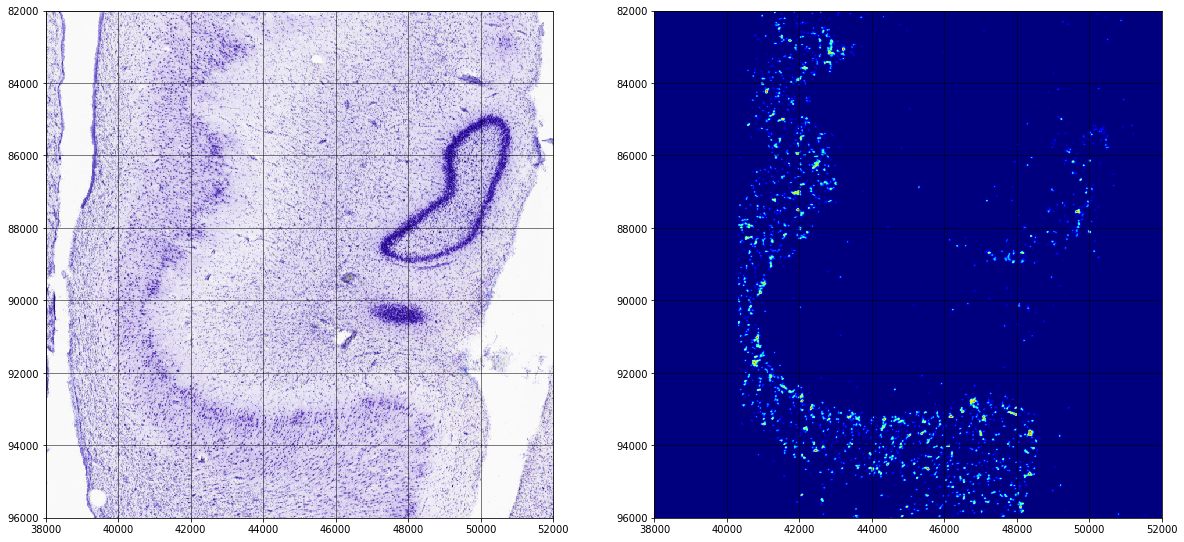

In [34]:
plot_classification_region(38000,82000,52000,96000,4,(0,4),2,show_ticks=True)

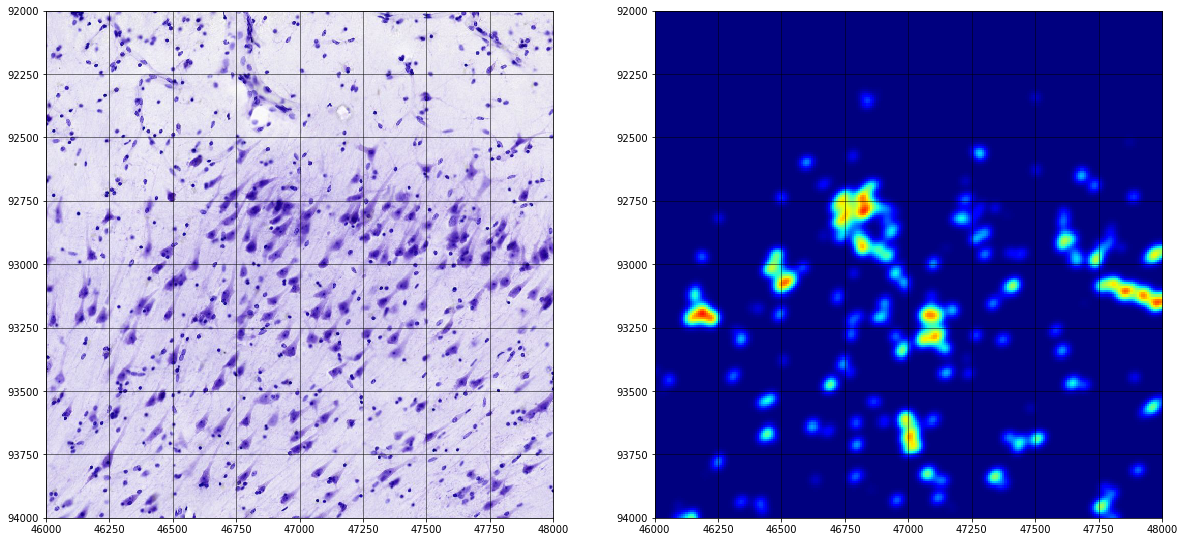

In [36]:
plot_classification_region(46000,92000,48000,94000,1,(0,4),2,show_ticks=True)

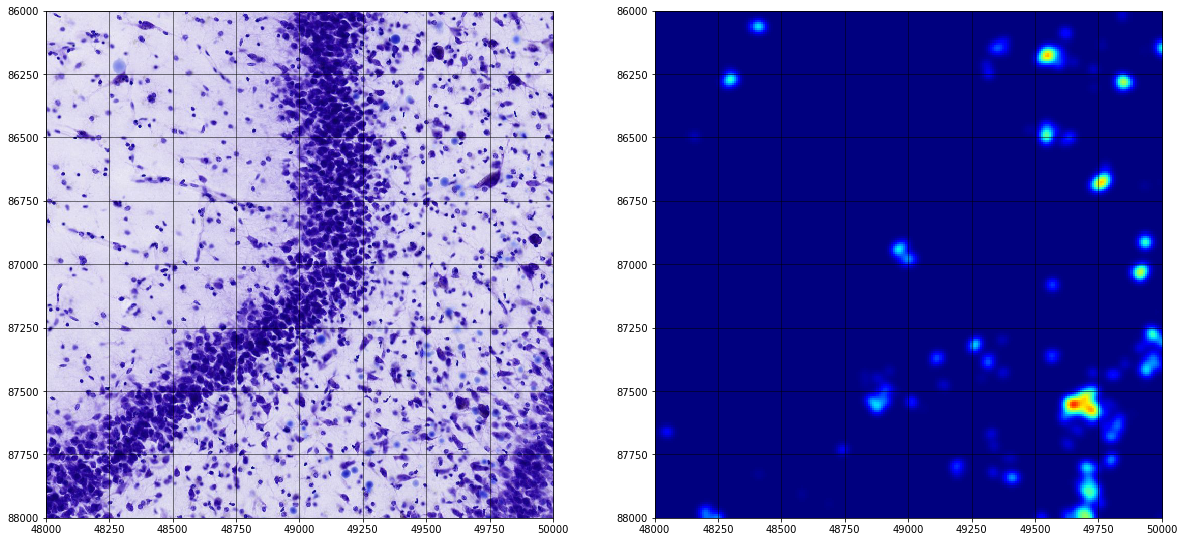

In [37]:
plot_classification_region(48000,86000,50000,88000,1,(0,4),2,show_ticks=True)